In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq

### entropy-based method

#### entropy

In [3]:
def rand_entropy(sequence):
    """
    Compute the "random entropy", that is, the entropy of a uniform distribution.
    Equation:
        S_{rand} = \log_{2}(n), where n is the number of unique symbols in the input sequence.
    Args:
        sequence: 1-D array-like sequence of symbols.
    Returns:
        A float representing the random entropy of the input sequence.
    Reference:
        Limits of Predictability in Human Mobility. Chaoming Song, Zehui Qu,
        Nicholas Blumm1, Albert-László Barabási. Vol. 327, Issue 5968, pp. 1018-1021.
        DOI: 10.1126/science.1177170
    """
    alphabet_size = len(np.unique(sequence))
    return np.log2(alphabet_size)


def unc_entropy(sequence):
    """
    Compute temporal-uncorrelated entropy (Shannon entropy).
    Equation:
    S_{unc} = - \sum p(i) \log_2{p(i)}, for each symbol i in the input sequence.
    Args:
        sequence: the input sequence of symbols.
    Returns:
        temporal-uncorrelated entropy of the input sequence.
    Reference:
        Limits of Predictability in Human Mobility. Chaoming Song, Zehui Qu,
        Nicholas Blumm1, Albert-László Barabási. Vol. 327, Issue 5968, pp. 1018-1021.
        DOI: 10.1126/science.1177170
    """
    _, counts = np.unique(sequence, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

In [4]:
def lambdas_naive(sequence): 
    lambdas = 0 
    n = len(sequence)
    for i in range(n):
        history = ''.join(sequence[0:i])
        k = 1
        found_mismatch = False
        while i + k <= n:
            sub_sequence = ''.join(sequence[i:i+k])
            if sub_sequence in history:
                k += 1
            else:
                found_mismatch = True
                break
        lambda_i = k
        lambdas += lambda_i
    return lambdas

In [5]:
def real_entropy(lambdas, n):
    """
    Estimate the entropy rate of the symbols encoded in the input sequence.

    Equation:
        S_{real} = \left( \frac{1}{n} \sum \Lambda_{i} \right)^{-1}\log_{2}(n)

    Args:
        sequence: the input sequence of symbols.
    Returns:
        A float representing the entropy rate of the input sequence.
    Reference:
        Kontoyiannis, I., Algoet, P. H., Suhov, Y. M., & Wyner, A. J. (1998).
        Nonparametric entropy estimation for stationary processes and random
        fields, with applications to English text. IEEE Transactions on Information
        Theory, 44(3), 1319-1327.
    """
    # return (1.0 * n / lambdas) * np.log(n)
    return (1.0 * n / lambdas) * np.log2(n)

#### max predictability

##### method 1

In [6]:
def compute_f(p,S,N):
    if p<=0 or p>=1 :
        print(p)
    h = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    # f(p) = h + (1 - p) * np.log2(N - 1) - S
    pi_max = h + (1 - p) * np.log2(N - 1) - S
    return pi_max
def getapproximation(p,S,N) :
    f= compute_f(p,S,N)
    # d1 = f'(p)
    d1 = np.log2(1-p) - np.log2(p) - np.log2(N-1)
    d2 = 1 / ((p-1)*p)
    return f/(d1-f*d2/(2*d1))
def max_predictability(S, N):
    """
    Estimate the maximum predictability of a sequence with
    entropy S and alphabet size N.
    Equation:
    $S = - H(\Pi) + (1 - \Pi)\log(N - 1),$
        where $H(\Pi)$ is given by
    $H(\Pi) = \Pi \log_2(\Pi) + (1 - \Pi) \log_2(1 - \Pi)$
    Args:
        S: the entropy of the input sequence of symbols.
        N: the size of the alphabet (number of unique symbols)
    Returns:
        the maximum predictability of the sequence.
    Reference:
        Limits of Predictability in Human Mobility. Chaoming Song, Zehui Qu,
        Nicholas Blumm1, Albert-László Barabási. Vol. 327, Issue 5968, pp. 1018-1021.
        DOI: 10.1126/science.1177170
    """
    if S>np.log2(N) :
        return 0
    if S<=0.01 :
        return 0.999
    p = (N+1)/(2*N)
    while(abs(compute_f(p,S,N))>0.0000001):
        p = p - 0.8*getapproximation(p,S,N)
    return p

##### method 2

In [6]:
def get_pimax(S, N):
    func = lambda x: -x * np.log2(x) - (1 - x) * np.log2(1 - x) + (1 - x) * (np.log2(N - 1)) - S
    p = (N+1)/(2*N)
    result = fsolve(func, p)
    return result[0]

##### method 3

In [7]:
def compute_f(p, S, N):
    """
    f(p) = -H(p) + (1 - p) * log2(N - 1) - S
    """
    if p <= 0.0 or p >= 1.0:
        return np.nan

    h = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return h + (1 - p) * np.log2(N - 1) - S


def max_predictability_brentq(S, N, tol=1e-8):
    """
    Maximum predictability using brentq (guaranteed convergence).
    """
    # trivial / boundary cases (same spirit as original code)
    if S >= np.log2(N):
        return 1.0 / N

    if S <= 0:
        return 1.0

    # strictly inside (0,1)
    eps = 1e-12
    p_min = eps
    p_max = 1.0 - eps

    # brentq requires opposite signs
    f_min = compute_f(p_min, S, N)
    f_max = compute_f(p_max, S, N)

    if np.isnan(f_min) or np.isnan(f_max):
        raise RuntimeError("Invalid function values at boundaries.")

    if f_min * f_max > 0:
        raise RuntimeError("Root not bracketed in (0,1).")

    return brentq(compute_f, p_min, p_max, args=(S, N), xtol=tol)

### Bayes_Error_Rate Based Method

In [7]:
from dataeval.metrics.estimators import ber

In [9]:
def sequence_to_feature_label(seq, r, state_map=None):
    """
    将离散时间序列转换为特征和标签，适用于贝叶斯错误率计算。
    
    参数：
        seq: list of str, 时间序列 ['A','B','C',...]
        r: int, 截断长度
        state_map: dict, 状态到整数的映射，比如 {'A':0,'B':1,'C':2}
        
    返回：
        X: np.ndarray, shape (num_samples, r), dtype=np.float64
        y: np.ndarray, shape (num_samples,), dtype=np.intp
    """
    if state_map is None:
        unique_states = sorted(set(seq))
        state_map = {s:i for i,s in enumerate(unique_states)}
    
    n = len(seq)
    num_samples = n - r
    X = np.zeros((num_samples, r), dtype=np.float64)
    y = np.zeros(num_samples, dtype=np.intp)
    
    for i in range(num_samples):
        # 历史 r 步作为特征
        X[i, :] = [state_map[s] for s in seq[i:i+r]]
        # 下一步作为标签
        y[i] = state_map[seq[i+r]]
    
    return X, y
'''
# 示例
r = 1
X, y = sequence_to_feature_label(seq, r)
print("Feature:\n", X)
print("Label:\n", y)
print(X.dtype, y.dtype)
'''

'\n# 示例\nr = 1\nX, y = sequence_to_feature_label(seq, r)\nprint("Feature:\n", X)\nprint("Label:\n", y)\nprint(X.dtype, y.dtype)\n'

### 实验1

In [9]:
def generate_sequence(q, n, states=['A','B','C']):
    """
    根据给定的转移矩阵生成长度为 n 的历史序列。
    
    参数:
        q: float, 对角线概率
        n: int, 序列长度
        states: list, 状态集，默认 ['A','B','C']
        
    返回:
        sequence: list, 长度为 n 的状态序列
    """
    # 构建转移矩阵
    P = np.array([
        [q, 2/3*(1-q), 1/3*(1-q)],
        [1/3*(1-q), q, 2/3*(1-q)],
        [2/3*(1-q), 1/3*(1-q), q]
    ])
    
    # 初始状态随机选择
    sequence = [np.random.choice(states)]
    
    for _ in range(1, n):
        current_state = sequence[-1]
        current_index = states.index(current_state)
        next_state = np.random.choice(states, p=P[current_index])
        sequence.append(next_state)
    
    return sequence

# 示例
seq = generate_sequence(q=0.6, n=5)
print(seq)

[np.str_('A'), np.str_('A'), np.str_('A'), np.str_('A'), np.str_('B')]


#### 基于熵的方法的不稳定性

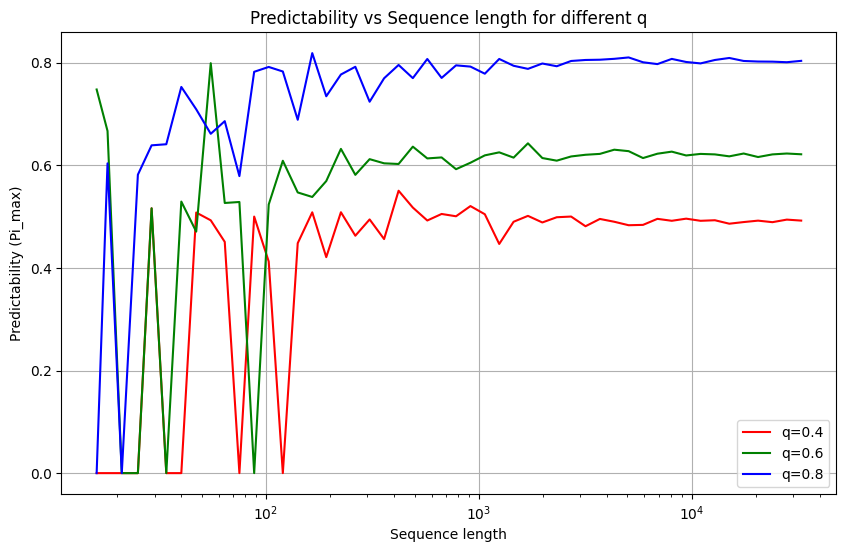

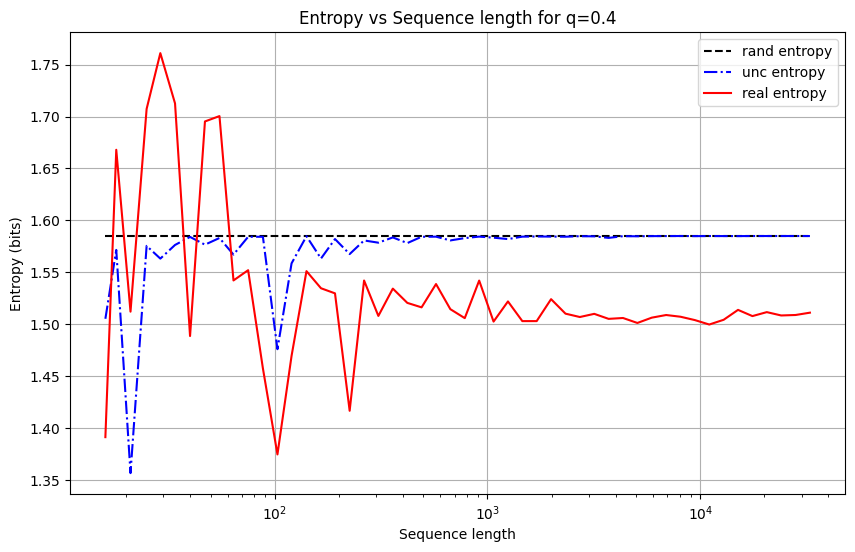

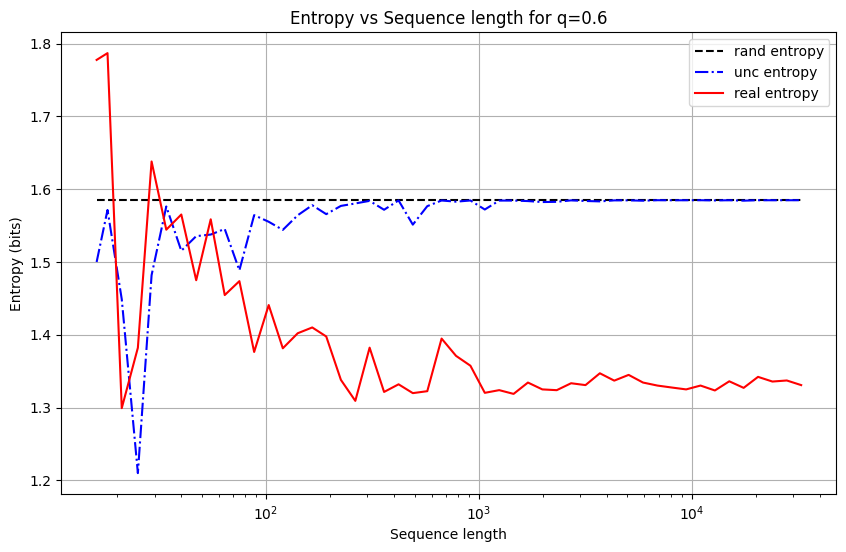

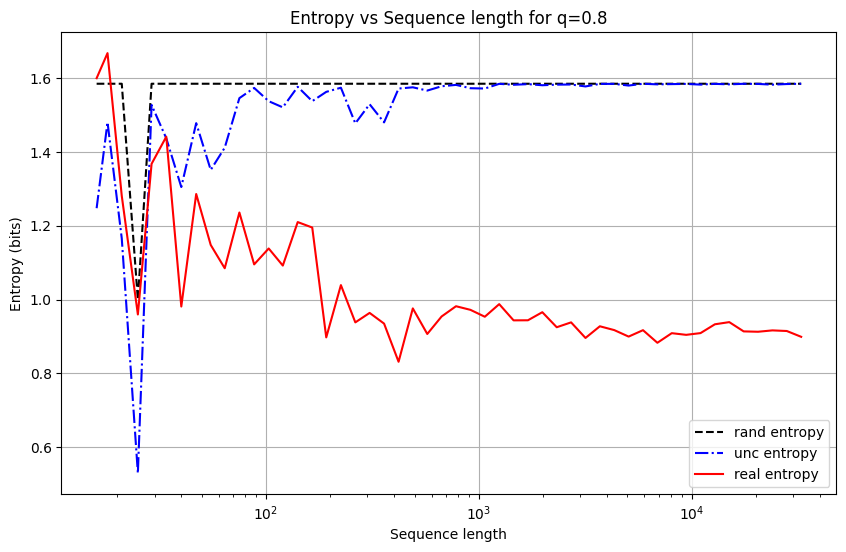

In [15]:
qs = [0.4, 0.6, 0.8]
lengths = np.logspace(4, 15, num=50, base=2, dtype=int)  # 50 个点，从 2^4 到 2^15
colors = ['r', 'g', 'b']

# -----------------------------
# 可预测性曲线（原来可以保留）
# -----------------------------
fig, ax0 = plt.subplots(figsize=(10,6))
for q, c in zip(qs, colors):
    pis = []
    for n in lengths:
        seq = generate_sequence(q, n)
        lambdas = lambdas_naive(seq)
        H = real_entropy(lambdas, len(seq))
        Pi_max = max_predictability(H, 3)
        pis.append(Pi_max)
    ax0.plot(lengths, pis, label=f'q={q}', color=c)
ax0.set_xscale('log')
ax0.set_xlabel('Sequence length')
ax0.set_ylabel('Predictability (Pi_max)')
ax0.set_title('Predictability vs Sequence length for different q')
ax0.legend()
ax0.grid(True)
plt.show()

# -----------------------------
# 三种熵，每个 q 单独画
# -----------------------------
for q, c in zip(qs, colors):
    S_rand_list = []
    S_unc_list = []
    S_real_list = []
    
    for n in lengths:
        seq = generate_sequence(q, n)
        S_rand_list.append(rand_entropy(seq))
        S_unc_list.append(unc_entropy(seq))
        lambdas = lambdas_naive(seq)
        S_real_list.append(real_entropy(lambdas, len(seq)))
    
    plt.figure(figsize=(10,6))
    plt.plot(lengths, S_rand_list, linestyle='--', color='black', label='rand entropy')
    plt.plot(lengths, S_unc_list, linestyle='-.', color='blue', label='unc entropy')
    plt.plot(lengths, S_real_list, linestyle='-', color='red', label='real entropy')
    
    plt.xscale('log')
    plt.xlabel('Sequence length')
    plt.ylabel('Entropy (bits)')
    plt.title(f'Entropy vs Sequence length for q={q}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 比较基于熵的方法和基于贝叶斯的方法

In [16]:
n = 2**15
qs = [0.4, 0.6, 0.8]
Pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

r = 1  # 滑动窗口长度

for q in qs:
    seq = generate_sequence(q, n)
    
    # 1️⃣ 基于熵
    lambdas = lambdas_naive(seq)
    H = real_entropy(lambdas, len(seq))
    Pi_max = max_predictability(H, 3)
    Pi_entropy.append(Pi_max)
    print("H =", H)
    print(f"q={q}: Pi_max (entropy) = {Pi_max}")
    
    # 2️⃣ 基于贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=1, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

    print(f"q={q}: Pi_max (Bayesian KNN) = {Pi_mean} (bounds: {Pi_lower}, {Pi_upper})")

H = 1.5086046818554315
q=0.4: Pi_max (entropy) = 0.4911703904473865
q=0.4: Pi_max (Bayesian KNN) = 0.4759564665039878 (bounds: 0.5488854968679567, 0.4030274361400189)
H = 1.3332971653329717
q=0.6: Pi_max (entropy) = 0.6227671108916437
q=0.6: Pi_max (Bayesian KNN) = 0.6784901882880114 (bounds: 0.7558572954273062, 0.6011230811487167)
H = 0.9088454896101831
q=0.8: Pi_max (entropy) = 0.8043324942005358
q=0.8: Pi_max (Bayesian KNN) = 0.8464648861868496 (bounds: 0.8917883801192968, 0.8011413922544023)


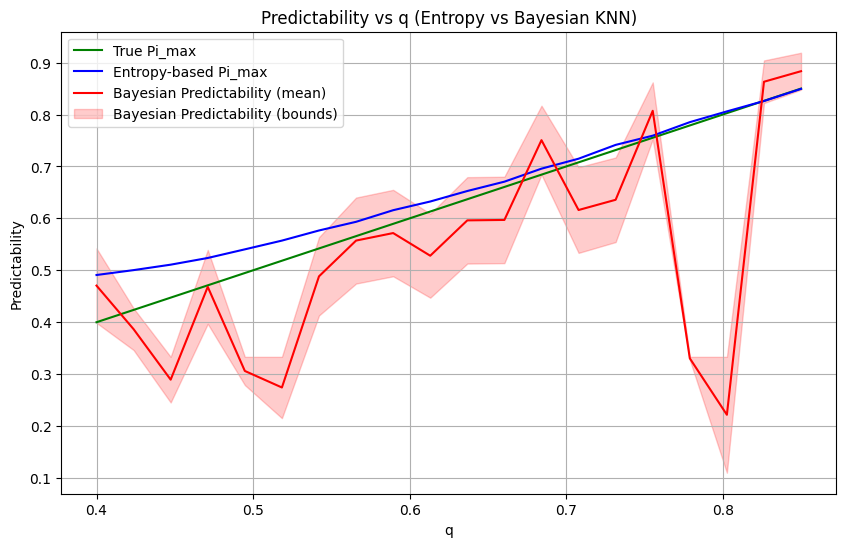

In [ ]:
n = 2**15
qs = np.linspace(0.4, 0.85, 50)
# qs = [0.4, 0.6, 0.8]
Pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

r = 1  # 滑动窗口长度

for q in qs:
    seq = generate_sequence(q, n)
    
    # 1️⃣ 基于熵
    lambdas = lambdas_naive(seq)
    H = real_entropy(lambdas, len(seq))
    Pi_max = max_predictability(H, 3)
    Pi_entropy.append(Pi_max)
    
    # 2️⃣ 基于贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=1, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

# 画图
plt.figure(figsize=(10,6))
plt.plot(qs, qs, label="True Pi_max", color='green')
plt.plot(qs, Pi_entropy, label="Entropy-based Pi_max", color='blue')
plt.plot(qs, BER_mean, label="Bayesian Predictability (mean)", color='red')
plt.fill_between(qs, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")
plt.xlabel("q")
plt.ylabel("Predictability")
plt.title("Predictability vs q (Entropy vs Bayesian KNN)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 实验参数
# -----------------------------
n = 2**15
qs = np.linspace(0.4, 0.85, 50)  # q 值
r_values = [3, 10, 96, 336]       # 历史窗口长度
k_values = [1, 3, 5]              # KNN 的 k 值

# -----------------------------
# 循环不同 r 和 k
# -----------------------------
for r in r_values:
    for k in k_values:
        Pi_entropy = []
        BER_upper = []
        BER_lower = []
        BER_mean = []

        for q in qs:
            seq = generate_sequence(q, n)

            # 1️⃣ 基于熵
            lambdas = lambdas_naive(seq)
            H = real_entropy(lambdas, len(seq))
            Pi_max = max_predictability(H, 3)
            Pi_entropy.append(Pi_max)

            # 2️⃣ 基于贝叶斯（KNN方法）
            X, y = sequence_to_feature_label(seq, r=r)
            X = X.astype(np.float64)
            y = y.astype(np.intp)

            ber_result = ber(X, y, k=k, method="KNN")
            Pi_upper = 1 - ber_result.ber
            Pi_lower = 1 - ber_result.ber_lower
            Pi_mean = (Pi_upper + Pi_lower)/2
            
            BER_upper.append(Pi_upper)
            BER_lower.append(Pi_lower)
            BER_mean.append(Pi_mean)

        # -----------------------------
        # 绘图
        # -----------------------------
        plt.figure(figsize=(10,6))
        plt.plot(qs, qs, label="True Pi_max", color='green')
        plt.plot(qs, Pi_entropy, label="Entropy-based Pi_max", color='blue')
        plt.plot(qs, BER_mean, label="Bayesian Predictability (mean)", color='red')
        plt.fill_between(qs, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")

        plt.xlabel("q")
        plt.ylabel("Predictability")
        plt.title(f"Predictability vs q (r={r}, k={k})")
        plt.legend()
        plt.grid(True)

        # -----------------------------
        # 保存图片
        # -----------------------------
        filename = f"predictability_r{r}_k{k}.png"
        plt.savefig(filename, dpi=300)
        plt.close()


d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\subprocess.py", line 1026,

### 实验2

In [16]:
def generate_sequence2(q, T, M=100, seed=None):
    """
    生成长度为 T 的状态序列，状态空间 Ω = {1, 2, ..., M}

    规则：
    - 以概率 1-q：ω_{t+1} 从 Ω 中均匀随机抽取
    - 以概率 q：若 ω_{t-1}=i, ω_t=j，则 ω_{t+1}=k=i+j (mod M)

    返回：
    - numpy.ndarray, shape (T,)
    """
    if seed is not None:
        np.random.seed(seed)

    # 构造符号表：S1, S2, ..., SM
    symbols = np.array([f"S{i}" for i in range(1, M + 1)], dtype=str)

    # 内部仍用整数推进
    seq_int = np.zeros(T, dtype=int)

    seq_int[0] = np.random.randint(1, M + 1)
    seq_int[1] = np.random.randint(1, M + 1)

    for t in range(1, T - 1):
        if np.random.rand() < q:
            k = seq_int[t - 1] + seq_int[t]
            if k > M:
                k -= M
            seq_int[t + 1] = k
        else:
            seq_int[t + 1] = np.random.randint(1, M + 1)

    # 映射为字符序列
    seq_str = symbols[seq_int - 1]

    return seq_str

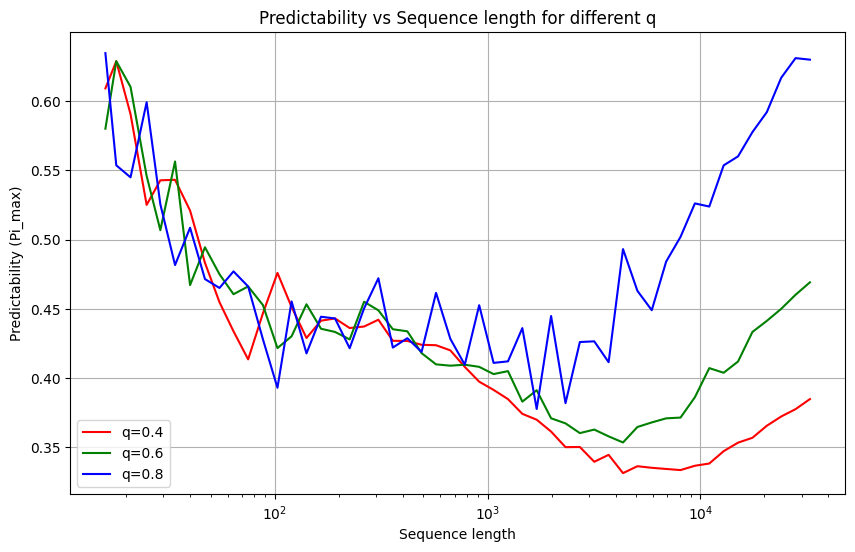

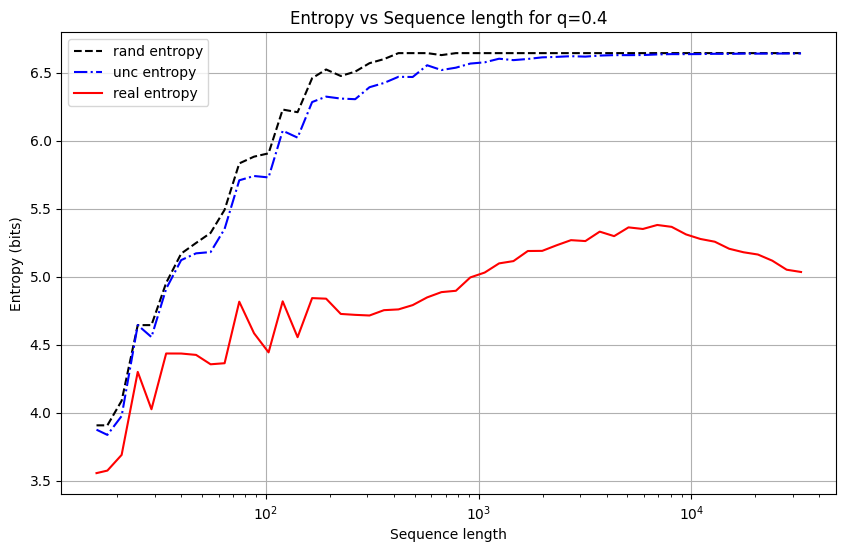

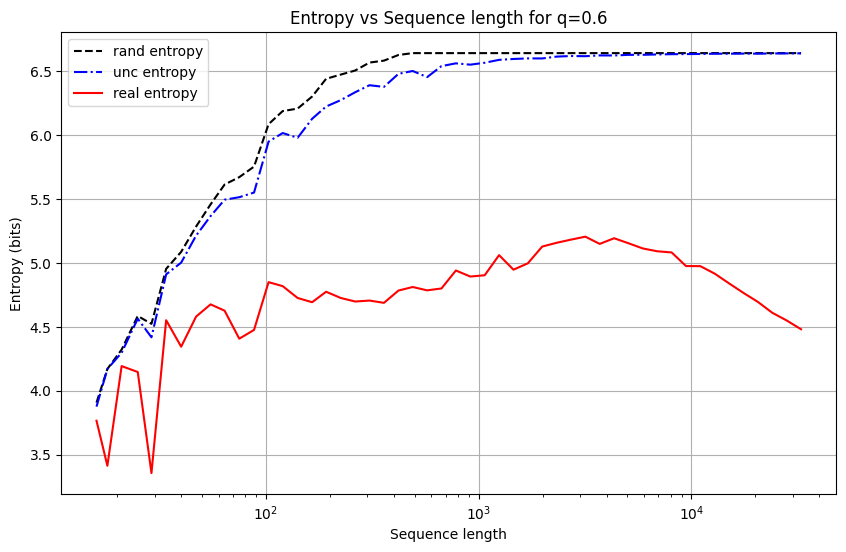

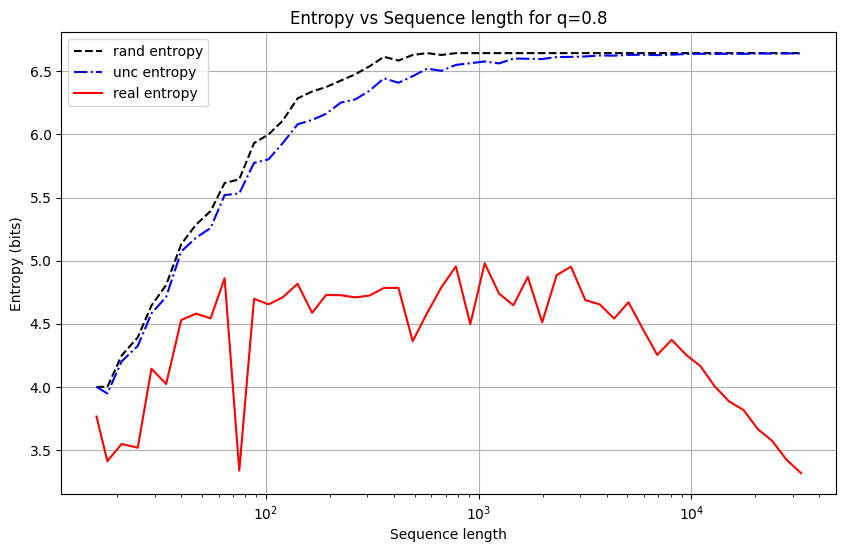

In [26]:
qs = [0.4, 0.6, 0.8]
lengths = np.logspace(4, 15, num=50, base=2, dtype=int)  # 50 个点，从 2^4 到 2^15
colors = ['r', 'g', 'b']

# -----------------------------
# 可预测性曲线（原来可以保留）
# -----------------------------
fig, ax0 = plt.subplots(figsize=(10,6))
for q, c in zip(qs, colors):
    pis = []
    for T in lengths:
        seq = generate_sequence2(q, T)
        lambdas = lambdas_naive(seq)
        H = real_entropy(lambdas, len(seq))
        Pi_max = max_predictability(H, 100)
        pis.append(Pi_max)
    ax0.plot(lengths, pis, label=f'q={q}', color=c)
ax0.set_xscale('log')
ax0.set_xlabel('Sequence length')
ax0.set_ylabel('Predictability (Pi_max)')
ax0.set_title('Predictability vs Sequence length for different q')
ax0.legend()
ax0.grid(True)
plt.show()

# -----------------------------
# 三种熵，每个 q 单独画
# -----------------------------
for q, c in zip(qs, colors):
    S_rand_list = []
    S_unc_list = []
    S_real_list = []
    
    for T in lengths:
        seq = generate_sequence2(q, T)
        S_rand_list.append(rand_entropy(seq))
        S_unc_list.append(unc_entropy(seq))
        lambdas = lambdas_naive(seq)
        S_real_list.append(real_entropy(lambdas, len(seq)))
    
    plt.figure(figsize=(10,6))
    plt.plot(lengths, S_rand_list, linestyle='--', color='black', label='rand entropy')
    plt.plot(lengths, S_unc_list, linestyle='-.', color='blue', label='unc entropy')
    plt.plot(lengths, S_real_list, linestyle='-', color='red', label='real entropy')
    
    plt.xscale('log')
    plt.xlabel('Sequence length')
    plt.ylabel('Entropy (bits)')
    plt.title(f'Entropy vs Sequence length for q={q}')
    plt.legend()
    plt.grid(True)
    plt.show()

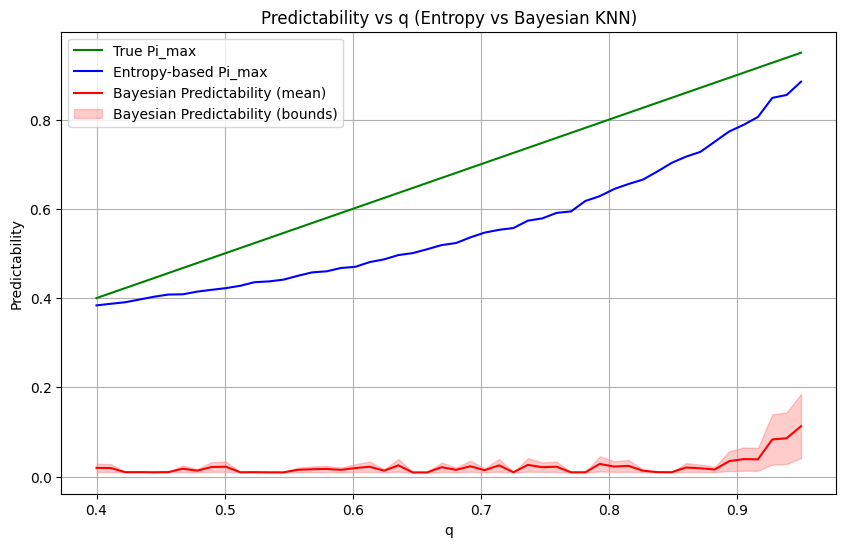

In [17]:
n = 2**15
qs = np.linspace(0.4, 0.95, 50)
# qs = [0.4, 0.6, 0.8]
Pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

r = 100  # 滑动窗口长度

for q in qs:
    seq = generate_sequence2(q, n)
    
    # 1️⃣ 基于熵
    lambdas = lambdas_naive(seq)
    H = real_entropy(lambdas, len(seq))
    Pi_max = max_predictability(H, 100)
    Pi_entropy.append(Pi_max)
    
    # 2️⃣ 基于贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=5, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

# 画图
plt.figure(figsize=(10,6))
plt.plot(qs, qs, label="True Pi_max", color='green')
plt.plot(qs, Pi_entropy, label="Entropy-based Pi_max", color='blue')
plt.plot(qs, BER_mean, label="Bayesian Predictability (mean)", color='red')
plt.fill_between(qs, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")
plt.xlabel("q")
plt.ylabel("Predictability")
plt.title("Predictability vs q (Entropy vs Bayesian KNN)")
plt.legend()
plt.grid(True)
plt.show()

### 实验3

In [10]:
def generate_sequence_third_char_largeM(n, M, q1=0.1, q2=0.2, q3=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    assert q1 + q2 + q3 <= 1.0
    
    # 用 Unicode 生成 M 个字符
    # chr(65) = 'A'，chr(65+M-1) 最多可生成任意 M
    Omega = np.array([chr(65 + i) for i in range(M)])
    
    seq = np.empty(n, dtype="<U1")
    seq[:3] = np.random.choice(Omega, size=3)
    
    for t in range(2, n-1):
        u = np.random.rand()
        if u < q1:
            seq[t+1] = seq[t]
        elif u < q1 + q2:
            seq[t+1] = seq[t-1]
        elif u < q1 + q2 + q3:
            seq[t+1] = seq[t-2]
        else:
            seq[t+1] = np.random.choice(Omega)
    return seq

In [11]:
def true_predictability(r: int, M: int, q1=0.1, q2=0.2, q3=0.3) -> float:
    qs = [q1, q2, q3]
    return max(qs[:r]) + (1 - q1 - q2 - q3) / M

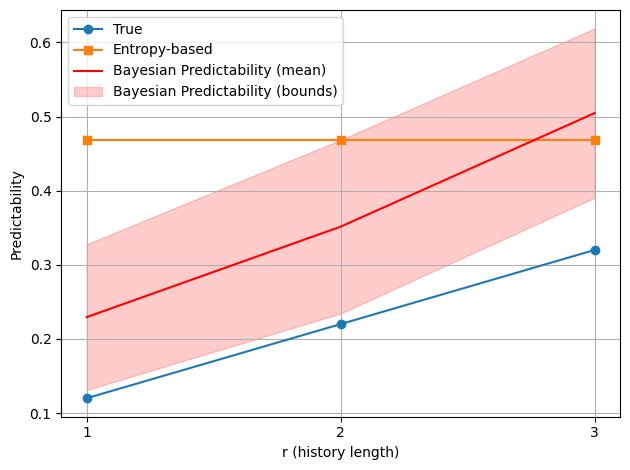

In [12]:
n = 2**15
M = 20
qs = (0.1, 0.2, 0.3)

seq = generate_sequence_third_char_largeM(
    n=n,
    M=M,
    q1=qs[0],
    q2=qs[1],
    q3=qs[2],
    seed=0
)

rs = [1, 2, 3]

pi_true = []
pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

for r in rs:
    pi_true.append(true_predictability(r, M))

    lambdas = lambdas_naive(seq)
    H = real_entropy(lambdas, len(seq))
    pi_entropy.append(max_predictability(H, M))
    
    # 2️⃣ 基于贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=5, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

plt.figure()
plt.plot(rs, pi_true, marker="o", label="True")
plt.plot(rs, pi_entropy, marker="s", label="Entropy-based")
plt.plot(rs, BER_mean, label="Bayesian Predictability (mean)", color='red')
plt.fill_between(rs, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")

plt.xlabel("r (history length)")
plt.ylabel("Predictability")
plt.xticks(rs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

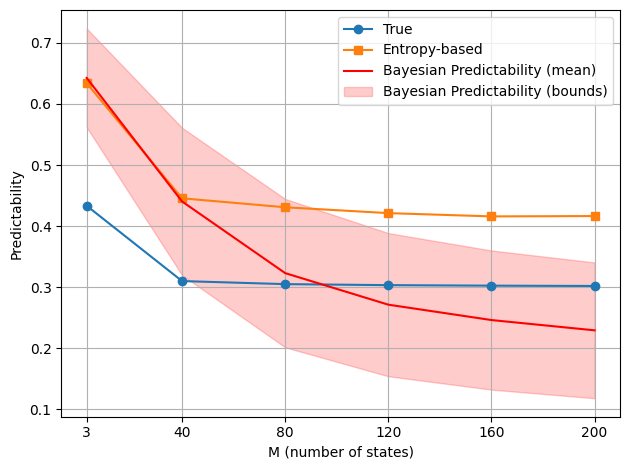

In [13]:
# -----------------------------
# 参数设置
# -----------------------------
n = 2**15
Ms = [3, 40, 80, 120, 160, 200]  # 状态空间大小
r = 3
qs = (0.1, 0.2, 0.3)

# 存储结果
pi_true = []
pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

# -----------------------------
# 对每个 M 生成序列并计算可预测性
# -----------------------------
for M in Ms:
    # 生成字符序列
    seq = generate_sequence_third_char_largeM(
        n=n,
        M=M,
        q1=qs[0],
        q2=qs[1],
        q3=qs[2],
        seed=0
    )

    # 1️⃣ 真实可预测性
    pi_true.append(true_predictability(r, M))

    # 2️⃣ 熵方法
    lambdas = lambdas_naive(seq)          # 将序列转为符号概率分布
    H = real_entropy(lambdas, len(seq))   # 估计熵率
    pi_entropy.append(max_predictability(H, M))

    # 3️⃣ 贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=5, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

# -----------------------------
# 画图
# -----------------------------
plt.figure()
plt.plot(Ms, pi_true, marker="o", label="True")
plt.plot(Ms, pi_entropy, marker="s", label="Entropy-based")
plt.plot(Ms, BER_mean, label="Bayesian Predictability (mean)", color='red')
plt.fill_between(Ms, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")

plt.xlabel("M (number of states)")
plt.ylabel("Predictability")
plt.xticks(Ms)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\ber\Lib\subprocess.py", line 1026,

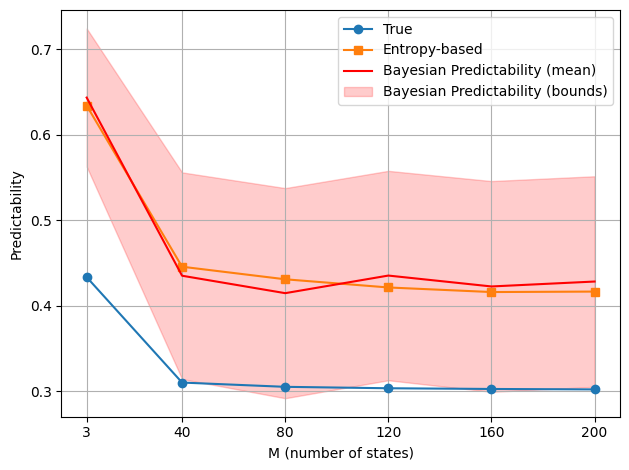

In [14]:
# -----------------------------
# 参数设置
# -----------------------------
n = 2**15
Ms = [3, 40, 80, 120, 160, 200]  # 状态空间大小
r = 336
qs = (0.1, 0.2, 0.3)

# 存储结果
pi_true = []
pi_entropy = []
BER_upper = []
BER_lower = []
BER_mean = []

# -----------------------------
# 对每个 M 生成序列并计算可预测性
# -----------------------------
for M in Ms:
    # 生成字符序列
    seq = generate_sequence_third_char_largeM(
        n=n,
        M=M,
        q1=qs[0],
        q2=qs[1],
        q3=qs[2],
        seed=0
    )

    # 1️⃣ 真实可预测性
    pi_true.append(true_predictability(r, M))

    # 2️⃣ 熵方法
    lambdas = lambdas_naive(seq)          # 将序列转为符号概率分布
    H = real_entropy(lambdas, len(seq))   # 估计熵率
    pi_entropy.append(max_predictability(H, M))

    # 3️⃣ 贝叶斯（KNN方法）
    X, y = sequence_to_feature_label(seq, r=r)
    X = X.astype(np.float64)
    y = y.astype(np.intp)
    
    ber_result = ber(X, y, k=5, method="KNN")
    Pi_upper = 1 - ber_result.ber
    Pi_lower = 1 - ber_result.ber_lower
    Pi_mean = (Pi_upper + Pi_lower)/2
    
    BER_upper.append(Pi_upper)
    BER_lower.append(Pi_lower)
    BER_mean.append(Pi_mean)

# -----------------------------
# 画图
# -----------------------------
plt.figure()
plt.plot(Ms, pi_true, marker="o", label="True")
plt.plot(Ms, pi_entropy, marker="s", label="Entropy-based")
plt.plot(Ms, BER_mean, label="Bayesian Predictability (mean)", color='red')
plt.fill_between(Ms, BER_lower, BER_upper, color='red', alpha=0.2, label="Bayesian Predictability (bounds)")

plt.xlabel("M (number of states)")
plt.ylabel("Predictability")
plt.xticks(Ms)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()